In [1]:
import os
import sys

sys.path.append('packages')

from ued_solid_state_FY19_utilities import *
from gas_phase_UED_cython_functions import *

from scipy.optimize import curve_fit

from tqdm import tqdm

# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy.ma as ma
import scipy.signal as ss
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline
import skimage.transform as skt
import concurrent.futures
import matplotlib
#%matplotlib inline

#Image stuff
import matplotlib.patches as patches
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage import util
import cv2
from pybaselines import Baseline

#ff stuff
from multiprocessing.dummy import Pool as ThreadPool

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.7 of module 'gas_phase_UED_cython_functions' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


## Input parameters

In [3]:
# Time scan folder path
# path_df = '/cds/group/ued/data/ueduu7703/SampleScreen/20210814/Run/20210814_1445/'
# path_df = '/sdf/data/lcls/ds/ued_testfac/scratch/jupyter_notebook_UED_solid_sample_codes/poly_crystal_demo_data/scan001/'
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1254/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1249/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1310/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1315/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1320/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1324/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1328/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1332/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1135/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1144/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1203/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1246/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1541/'; # data for the Bi scan 10/30, Temporal resolution
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1612/'; # data for the Bi scan 10/30, Temporal resolution
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_1141/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2319/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2329/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2335/';
path_df = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/';


# Image dimensions
num_row = 1024
num_col = 1024

# For azimuthal average
r_max = 500 # maximum radius to perform azimuthal average (in pixel)
s_cal = 0.02135 # s calibration (A-1 per pixel)
# s_cal = 0.0213 # s calibration (A-1 per pixel)
pre_t0_point_num = 4 # number of time points before time zero, use for difference pattern calculation

## Read in data

In [4]:
def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts


def get_image_details(file_names, sort=False):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    print(len(data_array))
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                folder_number = string[9][-3:]
                string = list(map(str, string[-1].split("-")))
                file_number = int(folder_number + string[1])
                file_order.append(int(file_number))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

In [11]:
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/';
runPath = "/*/*/ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253//*/*/ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
62
12


### Plotting Example Image

Load a image to check the signal level: /work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/scan005/images-ANDOR1/ANDOR1_Delay-003-108.8000_0001.tif
Total number of images in the chosen directory is 62


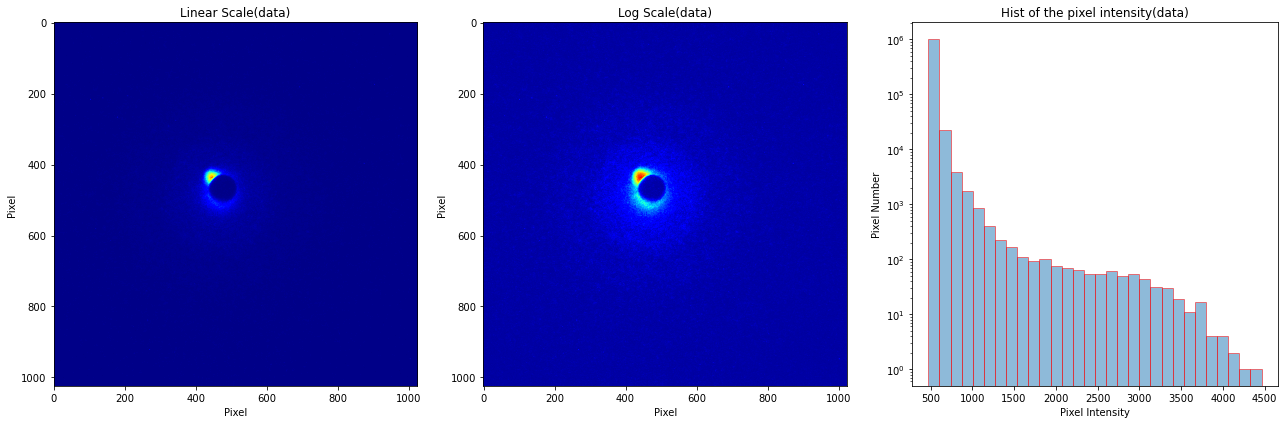

In [12]:
test=tf.imread(files[0]);
bkg_sign='no'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(18,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [13]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
print('Load diffraction signal');
good_data, good_stage, good_files, good_counts = get_image_details(files[:])


counts_mean = np.mean(good_counts)        # Mean values of Total Counts of all images
counts_std  = np.std(good_counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(good_stage)# Pump-probe stage position


print('Image number read: ', len(good_counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(good_files)))
#print(file_numbers)

Load diffraction signal
62
Image number read:  62
Stage positions:  9
62
CPU times: user 76.9 ms, sys: 110 ms, total: 187 ms
Wall time: 3.56 s


In [7]:
img_mean = np.nanmean(good_data, axis=0)

In [8]:
img_mean.shape

(1024, 1024)

### Visualizing Data Info

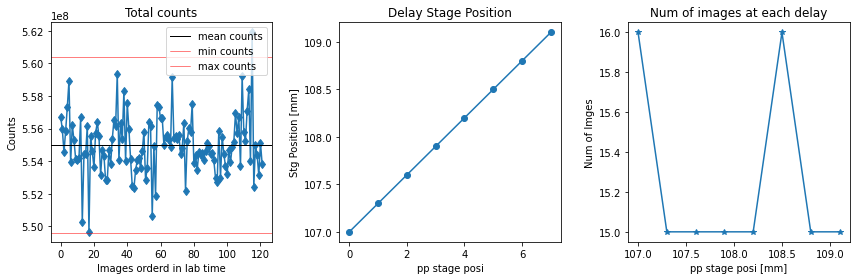

In [9]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(good_counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(good_stage,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Generate Background Based on Corners

Instead of subtracting background images, the function `backgroundNoise` generates a background based on the corners of the `mean_data` and then subtracts this generated background from all the data

In [10]:
def clean_and_filter(data_array):
    """Takes in a 3D array of data and applies the scipy.ndimage.median_filter on them. Need to consider the box size for these filters. 
        Additionally, issues can arise if the data array has nan values. 
        
        Returns: filtered data array of the same size as the input array"""
    
    print("Cleaning data")
    clean_data_array = []
    for data in data_array:
        new_data = data
        filt_data = mediand_filter(new_data, size=3)
        clean_data_array.append(np.array(filt_data))
    
    return clean_data_array

def _clean_and_filter(data_array_1d):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing. 
    Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. Eventually would like to add
    A baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    #corners = (np.median(data_array_1d[-50:, -50:]), np.median(data_array_1d[-50:, :50]), np.median(data_array_1d[:50, -50:]), 
                    #np.median(data_array_1d[:50, :50]))
    #floor = float(np.mean(corners))
    new_data = data_array_1d
    filt_data = median_filter(new_data, size=3)
    
    return filt_data


def clean_all(data_array):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _clean_and_filter. Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. 
    Eventually would like to add a baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    print('Cleaning all data with concurrent.futures.ProcessPoolExecutor')
    filtered_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_clean_and_filter, data_array)
        
    for result in results:
        filtered_data.append(result)
    
    filtered_data = np.array(filtered_data)
    print(filtered_data.shape)
    print("Finished cleaning!!")
    return filtered_data

def rmv_xrays_all(data_array):
    """ Requires global variables for the mean and standard deviation. Filters out any pixels that are more than 4 times the standard deviation of 
    the average pixel value by running the hidden function _remove_xrays in parallel. Use cleanMean if not a large dataset.
    
    Returns: xray removed data sets of the same shape."""
    print("Removing xrays from all data")
    clean_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_remove_xrays, data_array)
    for result in results:
        clean_data.append(result)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)
    clean_data = np.array(clean_data)
    print(clean_data.shape)
    
    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    
    return clean_data
        

def _remove_xrays(data_array_1d):
    upper_threshold = mean_data + 4*std_data
    clean_data = ma.masked_greater_equal(data_array_1d, upper_threshold)
    return clean_data
            
def cleanMean(data_array, std = 4, return_clean_data = True):
    """
    Takes in a data array and calculate the mean and standard deviation at each index across all images. Then applies a filter
    to the data that masks all values (replaces outliers with nan's) outside a given number of standard deviations. After, the 
    mean is taken, returning a 2 dimensional array with the mean data of non-outlier entries across all images.
    
    If return_clean_data is set to True, the cleaned data is returned as a 3d array without having the mean taken.
    
    Arguments:
    
    data_array (numpy.ndarray): Data array containing diffraction image data.
    std (int or float): Number of standard deviations from the mean allowed. Values outside this number of standard deviations
                        are masked as nan's. Set to 3 by default.
                        
    Returns:
    
    clean_mean_data (numpy.ndarray): Default. Returns a 2 dimensional array containing the mean values of the cleaned data.
    clean_data (numpy.ndarray): Other option. Returns the raw 3 dimensional array containing the cleaned data.
    
    Examples:
    
    example_array = np.array([[[8.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1., 2], [1,2]]])
    
    >>> cleanMean(example_array, std=1)
        np.array([[1.,2],[1.,2]])
    
    >>> cleanMean(example_array, std=1, return_clean_data = True)
        np.array([[[np.nan, 2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]]])
    """
    if len(data_array) == 0:
        raise ValueError("Input data array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data array is not 3 dimensional.")
    if std <= 0:
        raise ValueError("Number of standard deviations (std) must be non-negative.")
    if not isinstance(return_clean_data, bool):
        raise TypeError("return_clean_data must be a boolean value.")
   
    mean = np.mean(data_array, axis = 0)
    stDev = np.std(data_array, axis = 0)
    upper_threshold = mean + std*stDev
    #lower_threshold = mean - std*stDev
    clean_data = ma.masked_greater_equal(data_array, upper_threshold)
    #clean_data = ma.masked_outside(data_array, lower_threshold, upper_threshold)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)

    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    if return_clean_data == True:
        return clean_data
    else:
        clean_mean_data = np.mean(clean_data, axis = (0))
        return clean_mean_data
    
def medianFilter(data_array, center_top_left_corner, center_border_length, med_filter_range = 3):
    """
    Takes in a data array and applies scipy.signal's median filter. Then replaces the boundary and center values with the
    original values from the input array as to not lose precision in these parts. 
    
    Arguments:
    
    data_array (np.array): 2d Numpy array containing diffraction image data.
    center_top_left_corner (tuple): Tuple containing the row index (integer) and column index (integer) of the top left corner
                                    (lowest_index_row, lowest_index_column)
    center_border_length (int): Length of one side of the square. Must be an integer.
    med_filter_range (int): Must be odd. Initially set to 3. Shape of the square array for median filtering. Using an odd values makes it so that 
    the median filter is centered around the individual point.
    
    Returns:
    
    med_filt_data (2d-array): Array containing the median filtered data.
            
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a 2D numpy array.")
    if not isinstance(center_top_left_corner, tuple) or len(center_top_left_corner) != 2:
        raise ValueError("Center top left corner must be a tuple of length 2 that contains two integers.")
    if not isinstance(center_border_length, int):
        raise ValueError("center_border_length must be an integer.")
    #if not isinstance(center_top_left_corner[0] + center_border_length < data_array[0,-1]  
    if not (0 <= center_top_left_corner[0] < data_array.shape[0] and
        0 <= center_top_left_corner[1] < data_array.shape[1] and
        center_top_left_corner[0] + center_border_length <= data_array.shape[0] and
        center_top_left_corner[1] + center_border_length <= data_array.shape[1]):
        raise ValueError("""center_top_left_corner is out of bounds or adding center_border_length goes beyond the array.
                     Check that the tuple values are positive integers within the bounds of the data array and that 
                     adding the border length does not result in a value beyond the size of the array.""")
    if not isinstance(med_filter_range, int) and med_filter_range % 2 == 1:
        raise ValueError("med_filter_range must be an odd integer.")

    med_filt_data = ss.medfilt2d(data_array, med_filter_range)
    med_filt_data[0:med_filter_range//2,:] = data_array[0:med_filter_range//2,:]
    med_filt_data[-(med_filter_range//2):0,:] = data_array[-(med_filter_range//2):0,:]
    med_filt_data[:,0:med_filter_range//2] = data_array[:,0:med_filter_range//2]
    med_filt_data[:,-(med_filter_range//2):] = data_array[:,-(med_filter_range//2):]
    row_s, col_s = center_top_left_corner
    row_e, col_e = row_s+center_border_length, col_s+center_border_length
    med_filt_data[row_s:row_e,col_s:col_e] = data_array[row_s:row_e,col_s:col_e]
    return med_filt_data

def backgroundNoise(data_array, bkg_range = 20, remove_noise = False):
    """
    Takes in a 2d data array (using the mean array is recommended) and calculatees the means of the corners. Linearly interpolates values across 2d
    array to generate of background noise values using pandas.DataFrame.interpolate. Returns a two dimensional numpy array with the linearly 
    interpolated background noise.

    Arguments:

    data_array (2d np.ndarray): Data array used to generate the corner values of the background noise.
    bkg_range (int): Side length of square in each corner used for generating mean value. Initially set to 20.
    remove_noise (Bool): If set to true, generated background values are subtracted from the initial input array. Returns cleaned data.
    
    Returns:
    
    bkg_data (2d np.ndarray): Data array containing the linearly interpolated background noise for the image. If remove_noise = True,
                                returned data has background noise removed from original input.
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a numpy array.")
    if not isinstance(bkg_range, int) and bkg_range > 0:
        raise ValueError("bkg_range must be an integer > 0.")
    if not isinstance(remove_noise, bool):
        raise ValueError("remove_noise must be a boolean.")
    if not (2 * bkg_range < len(data_array[0,:]) and
            2 * bkg_range < len(data_array[:,0])):
        raise ValueError("2 * bkg-range must be less than both the number of rows and the number of columns.")

    empty_array = np.empty(np.shape(data_array))
    empty_array = (ma.masked_array(empty_array, mask = True))
    empty_array[0,0] = np.mean(data_array[0:20,0:20])
    empty_array[-1,0] = np.mean(data_array[-20:,0:20])
    empty_array[0,-1] = np.mean(data_array[0:20,-20:])
    empty_array[-1,-1] = np.mean(data_array[-20:,-20:])
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 0)
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 1)
    bkg_data = pd.DataFrame.to_numpy(empty_array)
    if remove_noise == True:
        return data_array - bkg_data
    else:
        return bkg_data
    
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered

def normalize_to_baseline(data):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[80:200])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, 80:200])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

def power_fit(data_array, x_vals, return_baseline=False):
    if len(data_array.shape) == 2:
        baseline2d = []
        for i in range(len(data_array)):
            temp_data = np.copy(data_array[i])
            idx_nan = ~np.isnan(temp_data)
            coeff = np.polyfit(x_vals[idx_nan],temp_data[idx_nan],2)
            baseline = np.polyval(coeff,x_vals)
            baseline2d.append(baseline)

        baseline2d = np.array(baseline2d)
        corrected_data = data_array - baseline2d
        
    elif len(data_array.shape) == 1:
        temp_data = data_array
        idx_nan = ~ np.isnan(temp_data)
        coeff = np.polyfit(x_vals[idx_nan], temp_data[idx_nan], 2)
        baseline2d = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline2d
    else:
        print("Data Array must be 1D or 2D array")
    if return_baseline == True:
        return corrected_data, baseline2d
    else:
        return corrected_data
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data

<Figure size 864x288 with 0 Axes>

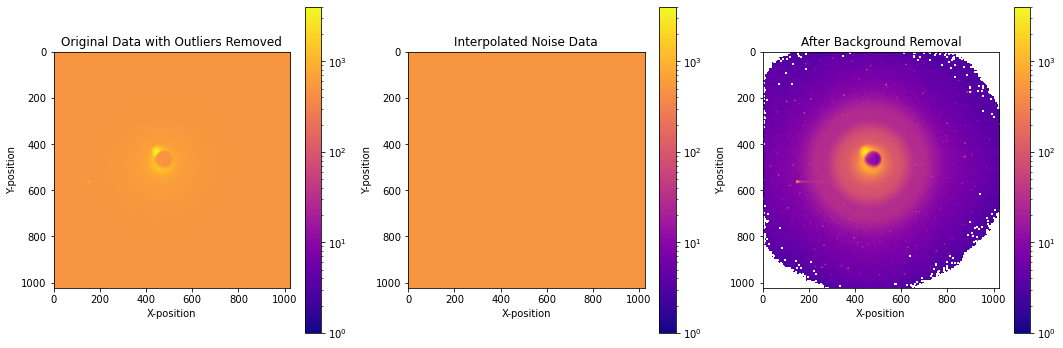

In [11]:
mean_data = np.mean(good_data, axis = 0)
std_data = np.std(good_data, axis = 0)

noise_data = backgroundNoise(mean_data)
noiseless_data = backgroundNoise(mean_data, remove_noise = True)

sub_edges = 'Yes'
if sub_edges =='Yes':
    good_data = good_data - noise_data
    good_counts = get_counts(good_data)

fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images
    
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
vmin_1_1, vmax_1_1 = 10**-0, 4000 

#Before
img1 = axes[0].imshow(mean_data, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))
axes[0].set_title('Original Data with Outliers Removed')
axes[0].set_xlabel('X-position')
axes[0].set_ylabel('Y-position')
colorbar1 = fig.colorbar(img1, ax=axes[0])  # Add colorbar to the first subplot

#Noise
img2 = axes[1].imshow(noise_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  
# Use the same normalization as img1
axes[1].set_title('Interpolated Noise Data')
axes[1].set_xlabel('X-position')
axes[1].set_ylabel('Y-position')
colorbar2 = fig.colorbar(img2, ax=axes[1])  # Add colorbar to the second subplot

# Noise Removed
img3 = axes[2].imshow(noiseless_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  # Logarithmic scaling
axes[2].set_title('After Background Removal')
axes[2].set_xlabel('X-position')
axes[2].set_ylabel('Y-position')
colorbar3 = fig.colorbar(img3, ax=axes[2])  # Add colorbar to the third subplot

# img4 = axes[3].plot(good_counts, '-d')
# axes[3].set_xlabel('Image Number');
# axes[3].set_ylabel('Counts');



## Generate Mask

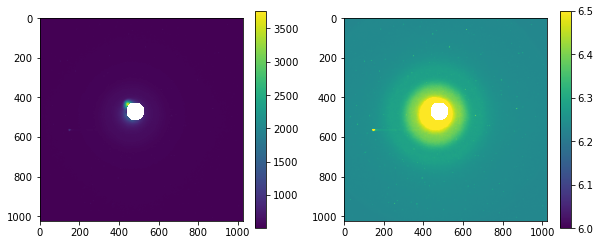

In [12]:
# cm_x = 503
# cm_y = 499

#cm_x = 524
#cm_y = 515

cm_x = 480
cm_y = 470

# cm = 1-gen_circular_mask(cm_x, cm_y, 187, num_col, num_row)
mask_hole =  1-gen_circular_mask(cm_x, cm_y, 40, 1024, 1024)
mask_hole[mask_hole<1] = np.nan

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow((img_mean)*mask_hole)
plt.colorbar()
#plt.clim([3000,4000])

plt.subplot(1,2,2)
plt.imshow(np.log(img_mean)*mask_hole)
plt.colorbar()
plt.clim([6, 6.5])

## Determination of centroid

[464.22876071 468.502521  ]


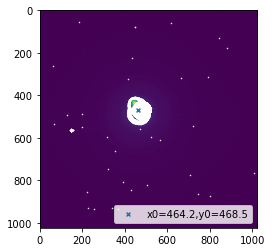

In [13]:
# low and high threshold to find ring centroid
threshold_low = 900
threshold_high = 1200
# threshold_low  = 1000
# threshold_high = 3200

center_diffraction = cal_one_diffraction_pattern_center_double_threshold(img_mean*mask_hole, threshold_low, threshold_high, flagPlot=12)
mask_diffraction = gen_circular_mask(center_diffraction[0], center_diffraction[1], 80, num_row, num_col)
mask_diffraction = (1 - mask_diffraction)*gen_circular_mask(center_diffraction[0], center_diffraction[1], 500, num_row, num_col)
print(center_diffraction)

# Uncomment this line if manual centroid input is needed
# center_diffraction = [504, 507]


## Averaging Based on Delay Position

In [14]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    if bkg_sign == 'Yes':
        stage_ave[i] = np.nanmean(stage_data,axis=0) - bkg_dlys_ave; # subtracting the background
    else:
        stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background
    #stage_ave[i][stage_ave[i]<0] = 0; # make negative values to 0 
    


Averaging data at stage posi # 0, 107.0 mm
Averaging data at stage posi # 1, 107.3 mm
Averaging data at stage posi # 2, 107.6 mm
Averaging data at stage posi # 3, 107.9 mm
Averaging data at stage posi # 4, 108.2 mm
Averaging data at stage posi # 5, 108.5 mm
Averaging data at stage posi # 6, 108.8 mm
Averaging data at stage posi # 7, 109.1 mm
CPU times: user 588 ms, sys: 262 ms, total: 850 ms
Wall time: 849 ms


## Azimuthal average

In [15]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

def get_average_old(array):
    """Return the average and standard deviation of an array"""
    Sum = 0
    Sum_squared = 0
    for element in array:
        if element == None:
            continue # Skip empty values
        Sum += element
        Sum_squared += element**2
    length = len(array)
    if length == 0:
        return 0, 0
    average = Sum / length 
    stdev = sqrt(Sum_squared / length - average**2) # sigma^2 = <X^2> - <X>^2
    return average, stdev

def get_average(array):
    average = np.nanmean(array)
    stdev = np.nanstd(array)
    return average, stdev

def get_radial_distribution(image):
    """Get average radial intensity after eliminating outliers"""
    radial_range = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER)) #half the size of the image i.e. 512 for 1024 by 1024 image
    radial_values = [[] for r in range(radial_range)]
    # First get all pixel values for each radial position as an array that we can average over later
    # It will look like
    #   [ (R = 0 values) [...],
    #     (R = 1 values) [...],
    #     (R = 2 values) [...], etc ]

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            R_index = int(round(R))
            if R_index < len(radial_values):
                radial_values[R_index].append(image[X][Y])
    # So now we have an array where, for each R value, we have a sub-array of each pixel intensity at that R
    # We want to first calculate the average and standard deviation
    # Then eliminate all outliers that are >3sigma away from the average
    # Then re-calculate the average with all outliers removed
    radial_averages, radial_stdevs = [], []
    for r_values in radial_values:
        avg, stdev = get_average(r_values)
        # Create new list with outliers removed
        new_r_values = [r if abs(avg - r) <= 5*stdev else np.nan for r in r_values]
        new_avg, new_stdev = get_average(new_r_values)
        radial_averages.append(new_avg)
        radial_stdevs.append(new_stdev)
    
    return radial_averages, radial_stdevs

def remove_radial_outliers(image):
    """After finding average radial values, replace all outlier pixels with the average value at that radius"""
    radial_avgs, radial_stdevs = get_radial_distribution(image)

    new_image = [[0 for Y in range(GRID_SIZE)] for X in range(GRID_SIZE)] # image of all zeros

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            # Calculate the interpolated value for the average and stdev at this R
            # (Same thing I do in simulate_image but now I'm calculating the weighted average of the 
            # average intensity values so the language is a little confusing)
            interpolated_avg, interpolated_stdev = 0, 0 # Will be filled in with the interpolated values

            R_lower = floor(R)
            R_upper = R_lower + 1
            if R_lower >= len(radial_avgs):
                interpolated_avg = 0 # R value is out of bounds, default to 0
                interpolated_stdev = 0
            elif R_upper >= len(radial_avgs):
                interpolated_avg = radial_avgs[R_lower] # R value is just outside of bounds, default to edge value
                interpolated_stdev = radial_stdevs[R_lower]
            else:
                # Calculate weighted average
                interpolated_avg = (R - R_lower) * radial_avgs[R_upper] + (R_upper - R) * radial_avgs[R_lower]
                interpolated_stdev = (R - R_lower) * radial_stdevs[R_upper] + (R_upper - R) * radial_stdevs[R_lower]
            
            if abs(image[X][Y] - interpolated_avg) <= 3*interpolated_stdev:
                # Value is within acceptance range, do not change
                new_image[X][Y] = image[X][Y] 
            else:
                # Value is outside acceptance range, use average value instead
                new_image[X][Y] = interpolated_avg
    
    return new_image

In [16]:
center_ave = center_diffraction
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(stage_ave, x, y)

max Q index is 464


## Normalize Azimuthal Averages to Baseline

In [19]:
def normalize_to_baseline(data):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[80:200])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, 80:200])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

<ipython-input-19-b38a3db3aae2>:3: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


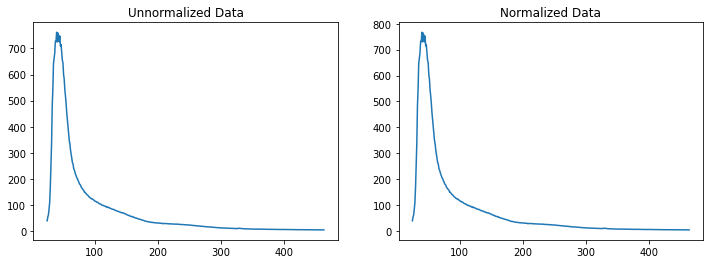

In [20]:
norm_data = normalize_to_baseline(azi_data) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

## Plot some results 

<ipython-input-22-f072b033b007>:13: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
<ipython-input-22-f072b033b007>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,uni_stage,dI_I_norm,cmap='bwr');


98


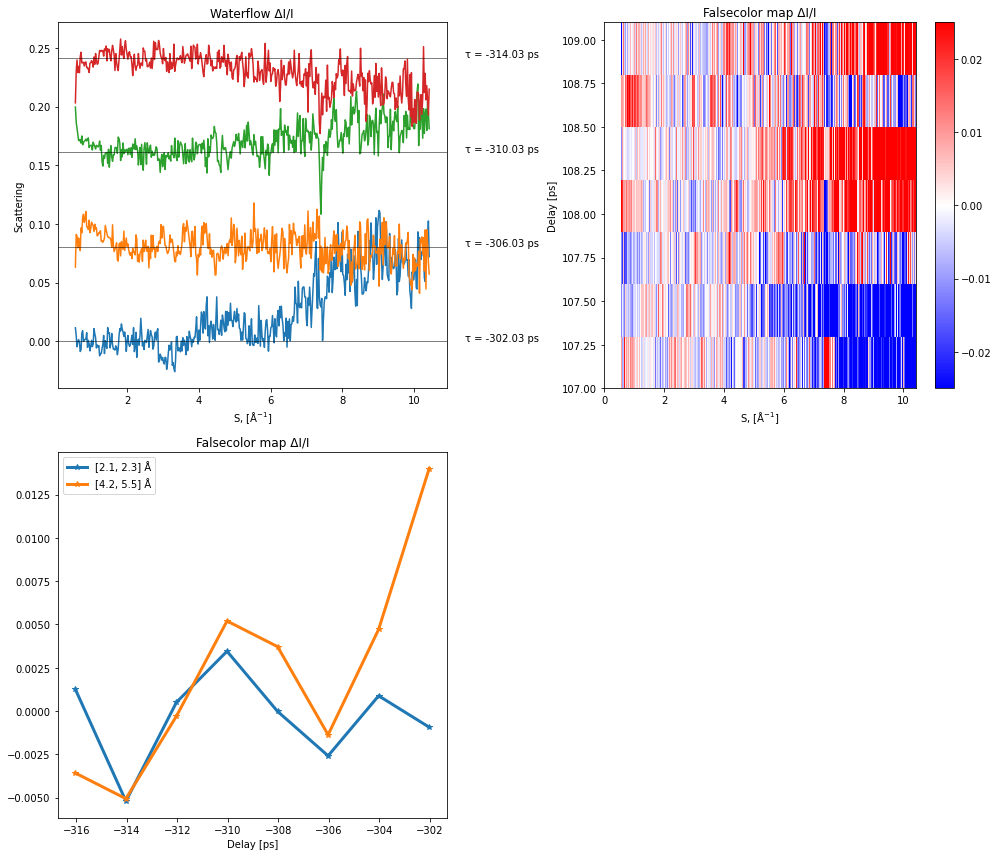

In [22]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0225 # S calibration in experiment
posi_0    = 154.405 # The reference T0
#posi_0 = 108.61
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 5
norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,uni_stage,dI_I_norm,cmap='bwr');
plt.clim(vmin=-0.025, vmax=0.025);
plt.colorbar()
#plt.ylim(-0.5, 1.5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [4.2, 5.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

In [57]:
delay_unique = np.unique(good_stage)
rad_pro_avg = np.zeros((r_max, len(delay_unique)))
rad_pro_std = np.zeros((r_max, len(delay_unique)))

for (ind_de, de) in enumerate(delay_unique):
    ind = np.where(good_stage==de)
    rad_pro_avg[:,ind_de] = rad_pro_set[:,ind[0]].mean(axis=1)
    rad_pro_std[:,ind_de] = rad_pro_set[:,ind[0]].std(axis=1)
        
rad_pro_avg_pre_t0 = rad_pro_avg[:,-pre_t0_point_num:].mean(axis=1)

rad_pro_avg_diff = np.zeros_like(rad_pro_avg)
rad_pro_std_diff = np.zeros_like(rad_pro_avg)

for i in np.arange(rad_pro_avg.shape[1]):
    rad_pro_avg_diff[:,i] = ( rad_pro_avg[:,i] - rad_pro_avg_pre_t0 ) / rad_pro_avg_pre_t0 * 100
    rad_pro_std_diff[:,i] = rad_pro_std[:,i] / rad_pro_avg_pre_t0 * 100
        
s1 = 2.95
s2 = 5.17
s3 = 7.88

plt.figure(figsize=(5,5))
plt.plot(inten_mean_set, label=r'RMS intensity %2.1f %%'%(np.std(inten_mean_set)/np.mean(inten_mean_set)*100))
plt.xlabel('Image number')
plt.legend()
plt.ylabel('Total intensity (arb. u.)')

plt.figure(figsize=(5,5))
plt.plot(s, rad_pro_avg[:,0], 'k-')
plt.fill_between(s, rad_pro_avg[:,0]-rad_pro_std[:,0], rad_pro_avg[:,0]+rad_pro_std[:,0], alpha=0.8)

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_unique, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.axhline(y=s1,color='r');
plt.axhline(y=s2,color='b');
plt.axhline(y=s3,color='g');
plt.colorbar() 
plt.xlabel('Delay (mm)')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*(delay_unique.max()-delay_unique.min())/3+delay_unique.min(), s, 'k-', linewidth=2)

delay_points = np.arange(len(delay_unique))

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_points, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.colorbar() 
plt.xlabel('Delay scan point')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_points.max()/3, s, 'k-', linewidth=2)

delay_time = ( delay_unique - delay_unique[0] ) / 0.15

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_time, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.colorbar() 
plt.xlabel('Delay time (ps)')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_time.max()/3, s, 'k-', linewidth=2)


IndexError: index 43 is out of bounds for axis 1 with size 32

In [58]:
# s1 = 7.5
# s2 = 4.98
# s3 = 5.76

s1 = 4.76 #3
# s2 = 5.11
s2 = 2.7 #5.18
s3 = 7.25 #7.80

r1 = int(s1 / s_cal)
r2 = int(s2 / s_cal)
r3 = int(s3 / s_cal)

r_half_width = 5

inten_avg_1 = np.mean(rad_pro_avg_diff[r1-r_half_width:r1+r_half_width,:], axis=0)
inten_std_1 = np.sqrt(np.mean(rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:].shape[0]

inten_avg_2 = np.mean(rad_pro_avg_diff[r2-r_half_width:r2+r_half_width,:], axis=0)
inten_std_2 = np.sqrt(np.mean(rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:].shape[0]

inten_avg_3 = np.mean(rad_pro_avg_diff[r3-r_half_width:r3+r_half_width,:], axis=0)
inten_std_3 = np.sqrt(np.mean(rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:].shape[0]

plt.figure(figsize=(11, 6))

plt.subplot(2,3,1)
plt.errorbar(delay_unique, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.xlabel('Time delay (mm)')
plt.title(path_df[-14:])
plt.legend()

plt.subplot(2,3,2)
plt.errorbar(delay_unique, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
plt.xlabel('Time delay (mm)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.subplot(2,3,3)
plt.errorbar(delay_unique, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.xlabel('Time delay (mm)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

# plt.tight_layout()
# plt.show()

T0 = 37.895 #mm
Time_real = -(delay_unique-T0)/0.15 # ps
print(delay_unique)
# plt.figure(figsize=(11, 3))
plt.subplot(2,3,4)
plt.errorbar(Time_real, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.xlabel('Time delay (ps)')
plt.title(path_df[-14:])
plt.legend()

plt.subplot(2,3,5)
plt.errorbar(Time_real, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
plt.xlabel('Time delay (ps)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.subplot(2,3,6)
plt.errorbar(Time_real, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.xlabel('Time delay (ps)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.tight_layout()
plt.show()

# fitting with an error function


NameError: name 'rad_pro_avg_diff' is not defined

In [59]:
# Generate sample data

# Define the error function
def error_function(x, a, b, c, d):
    return a * np.exp(-b * (x - c) ** 2) + d

def t0_finder(x, a, b, tau, p0):
    """
    Exponential function for fitting data.

    """
    y = np.piecewise(x, [x < p0, x >= p0], [lambda x: a, lambda x: a + b*(np.exp(-(x-p0)/tau) - 1)])
    return y
    
def expo_fitting(x, y, bounds, func=t0_finder):
    popt, pcov = curve_fit(func, x, y, bounds=bounds)
    error = np.sqrt(np.diag(pcov))
    return func(x, *popt), popt, error

# x_data = np.linspace(-2, 2, 100)
# y_data = 3 * np.exp(-2 * x_data ** 2) + 0.5

# Add some noise to the data
# np.random.seed(0)
# y_data += 0.2 * np.random.normal(size=len(x_data))

# Fit the data to the error function
params, covariance = curve_fit(error_function, Time_real, inten_avg_3)

bounds = ([-1, -20, 0.1, -1], [1, 20, 20, 1])
fit3, popt3, error3 = expo_fitting(Time_real, inten_avg_3, bounds=bounds, func=t0_finder)
fit2, popt2, error2 = expo_fitting(Time_real, inten_avg_2, bounds=bounds, func=t0_finder)
fit1, popt1, error1 = expo_fitting(Time_real, inten_avg_1, bounds=bounds, func=t0_finder)

# Generate points for the fitted curve
# x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(Time_real, *params)

# Plot the original data and the fitted curve
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,5))

ax1.errorbar(delay_unique, inten_avg_1, inten_std_1, color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
ax1.scatter(delay_unique, inten_avg_1, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax1.plot(delay_unique, fit1, label='Fitted curve', color='black')             
ax1.legend()

ax2.errorbar(delay_unique, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
ax2.scatter(delay_unique, inten_avg_2, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax2.plot(delay_unique, fit2, label='Fitted curve', color='black')             
ax2.legend()


ax3.errorbar(delay_unique, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
ax3.scatter(delay_unique, inten_avg_3, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax3.plot(delay_unique, fit3, label='Fitted curve', color='black')             
ax3.legend()

plt.tight_layout()
plt.show()

print(params)
print(popt1)
print(popt2)
print(popt3)
print('fit1: ',T0-(popt1[3]*0.15))# ps
print('fit2: ',T0-(popt2[3]*0.15))# ps
print('fit3: ',T0-(popt3[3]*0.15))# ps
print('mean: ',np.mean([T0-(popt1[3]*0.15),T0-(popt2[3]*0.15),T0-(popt3[3]*0.15)]))# ps


NameError: name 'Time_real' is not defined

In [27]:
popt3

array([ 0.06170163, -2.81255221, 20.        , -0.5       ])

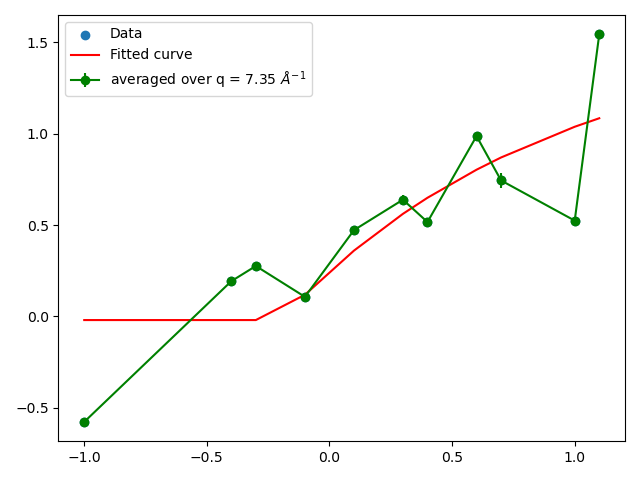

[ 1.60627734e+00  1.68267808e+02  1.02241034e+00 -2.13907968e-02]
[-0.01958513 -1.59330593  1.10133514 -0.2       ]
37.925000000000004


In [28]:
bounds = ([-0.5, -6, 0.1, -0.2], [0.5, 6, 20, 0.2])
fit, popt, error = expo_fitting(Time_real, inten_avg_2, bounds=bounds, func=t0_finder)

# Generate points for the fitted curve
# x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(Time_real, *params)

# Plot the original data and the fitted curve
plt.figure()
plt.errorbar(Time_real, inten_avg_2, inten_std_2, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.scatter(Time_real, inten_avg_2, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
plt.plot(Time_real, fit, label='Fitted curve', color='r')             
plt.legend()

plt.tight_layout()
plt.show()

print(params)
print(popt)
print(T0-(popt[3]*0.15))# ps

In [53]:
inten_avg_3

array([-4.20575707, -3.84673114, -4.25586234, -3.80689799, -3.70651873,
       -3.320837  , -3.31738533, -2.75817826, -3.20992754, -3.26239646,
       -2.45200341, -2.62642739, -2.46162854, -2.7994432 , -2.23458146,
       -1.12728356, -0.57508033,  0.22180964, -0.05172625, -0.14366452,
       -0.02641887])

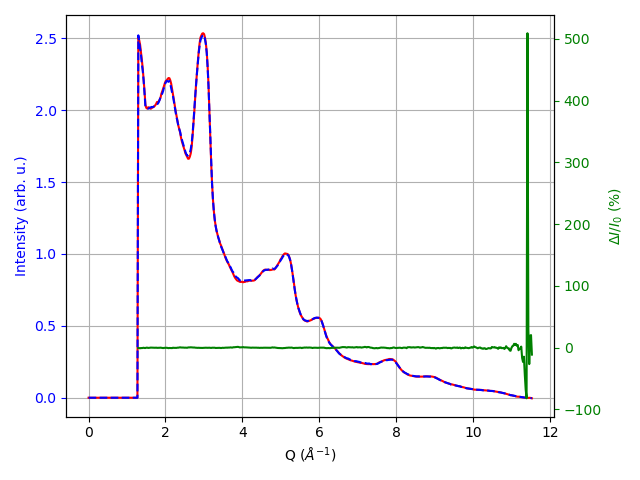

In [29]:
fig, ax1 = plt.subplots()
ax1.plot(s, rad_pro_avg[:,-1], 'r-',label='Before t0')
ax1.plot(s, rad_pro_avg[:,1], 'b--', label='After t0')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Intensity (arb. u.)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(s, rad_pro_avg_diff[:,1], 'g-', label=r'$\Delta I/I_0$')
ax2.set_ylabel(r'$\Delta I/I_0$ (%)', color='g')
ax2.tick_params('y', colors='g')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1+h2, l1+l2, loc='best', fram240240eon=False)
ax1.set_xlabel(r'Q ($\AA^{-1}$)')
fig.tight_layout()

In [ ]:
# Define the error function
def error_function(x, a, b, c, d):
    return a * np.exp(-b * (x - c) ** 2) + d

# Generate sample data
x_data = np.linspace(-2, 2, 100)
y_data = 3 * np.exp(-2 * x_data ** 2) + 0.5

# Add some noise to the data
np.random.seed(0)
y_data += 0.2 * np.random.normal(size=len(x_data))

# Fit the data to the error function
params, covariance = curve_fit(error_function, Time_real, y_data)

# Generate points for the fitted curve
x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(x_fit, *params)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit, y_fit, label='Fitted curve', color='r')
plt.legend()
plt.show()